# Comparison of each of our transforms with the real bulks.

The following notebook imports the previously processed bulks of adipose tissue, the previously calculated DEGs lists, and the previously trained models. You must run process_bulks_train_models.py beforehand.

The goal is to find the transformation that, when applied to SN cells, causes pseudobulks to cluster closer to real bulks. We hypothesize bulks with the more accurate transfromation will cluster closer to real bulks in tSNE and PCA space measured by eucledian distance.

## Imports and settings

In [9]:
# Parameters
res_name = "ADP"

In [10]:
import os, re, glob, sys
import pickle
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import bootstrap
import seaborn as sns
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns, matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
from matplotlib.ticker import FormatStrFormatter
import anndata
import scanpy as sc
from sklearn.preprocessing import StandardScaler
import itertools, numpy as np, pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import root_mean_squared_error

sys.path.insert(1, "../../")
sys.path.insert(1, "../")
from src.helpers import (
    prepare_data,
    split_single_cell_data,
    pick_cells,
    save_comparison_pseudobulks,
)
from src.helpers import (
    downsample_cells_by_type,
    make_references,
    save_bayesprism_references,
    open_adipose_datasets_all,
)
from src.helpers import (
    make_pseudobulks,
    save_bayesprism_pseudobulks,
    save_cibersort,
    scvi_train_model,
)
from src.deg_funct import (
    create_fixed_pseudobulk,
    load_others_degs,
    run_deseq2_for_cell_type,
    load_or_calc_degs,
)
from src.deg_funct import (
    differential_expression_analysis,
    remove_diff_genes,
    differential_expression_analysis_parallel,
)
from src.transforms import (
    transform_heldout_sn_to_mean_sc_VAE,
    transform_heldout_sn_to_mean_sc_local,
)
from src.transforms import (
    transform_heldout_sn_to_mean_sc,
    calculate_median_library_size,
    get_normalized_expression_from_latent,
)

In [11]:
# Palettes & transform names
display_palette = {
    "Real": "black",
    "scRNA All (Ctrl)": "#1f77b4",
    "snRNA All (Ctrl)": "firebrick",
    "snRNA": "rosybrown",
    "PCA": "#2ca02c",
    "scVILS": "darkorange",
    "scVIcond": "#9467bd",
}

palette_all = {
    "snRNA All (NegCtrl)": "firebrick",
    "snRNA": "rosybrown",
    "PCA": "#2ca02c",
    "scVILS": "darkorange",
    "scVIcond": "#9467bd",
}

display_palette_deg = {
    "snRNA (-DEG)": "lightcoral",
    "PCA (-DEG)": "#98df8a",
    "scVILS (-DEG)": "sandybrown",
    "scVIcond (-DEG)": "#c5b0d5",
}

display_names = {
    "sn_raw_real": "snRNA All (NegCtrl)",
    "rawSN": "snRNA",
    "degSN": "snRNA (-DEG)",
    "degOtherSN": "-DEG Other Datasets",
    "degIntSN": "-DEG Intersection (3)",
    "degRandSN": "-Random Genes",
    "pcaSN": "PCA",
    "degPCA_SN": "PCA (-DEG)",
    "scvi_LSshift_SN": "scVILS",
    "degScviLSshift_SN": "scVILS (-DEG)",
    "scviSN": "scVIcond",
    "degScviSN": "scVIcond (-DEG)",
}

display_order = [
    "snRNA",
    "PCA",
    "scVILS",
    "scVIcond",
]

display_order_deg = ["snRNA (-DEG)", "PCA (-DEG)", "scVILS (-DEG)", "scVIcond (-DEG)"]

## Reading in previously made pseudobulks

See script for details: deconvolution_differences/scripts/prepare_real_bulk_clustering.py

In [12]:
# -----------------------------
# PARAMETERS
# -----------------------------
DATASET_NAME = res_name
# Set base paths (relative to the notebook’s location)
base_dir = ".."  # adjust as needed
pseudos_save_path = f"{base_dir}/data/{res_name}/"
num_rand = 100
num_realistic = 100
num_cells = 1000

In [13]:
# ------------------------------------------------------------------
# 1.  Where the .pkl files live
# ------------------------------------------------------------------
save_dir = os.path.join(os.getcwd(), "..", "data", "Real_ADP", "bulks_for_comp")

# ------------------------------------------------------------------
# 2.  Load the real-bulk DataFrame
# ------------------------------------------------------------------
real_df = pd.read_pickle(os.path.join(save_dir, "bulk_df.pkl"))

# ------------------------------------------------------------------
# 3.  Load the “no-DEG” real bulk
# ------------------------------------------------------------------
real_df_nodeg = pd.read_pickle(os.path.join(save_dir, "bulk_df_nodeg.pkl"))

# ------------------------------------------------------------------
# 4.  Load all pseudobulk DataFrames
# ------------------------------------------------------------------
pseudobulk_dict = {}  # regular versions
pseudobulk_nodeg_dict = {}  # “no-DEG” versions

for fname in os.listdir(save_dir):

    fpath = os.path.join(save_dir, fname)

    # a) regular pseudobulks, e.g. "Transform_pseudobulk.pkl"
    if fname.endswith("_pseudobulk.pkl") and not fname.endswith("_nodeg.pkl"):
        key = fname.replace("_pseudobulk.pkl", "").replace("_", " ")
        if key in display_order:
            pseudobulk_dict[key] = pd.read_pickle(fpath)

    # b) “no-DEG” pseudobulks, e.g. "MyTransform_pseudobulk_nodeg.pkl"
    elif fname.endswith("_pseudobulk_nodeg.pkl"):
        key = fname.replace("_pseudobulk_nodeg.pkl", "").replace("_", " ")
        pseudobulk_nodeg_dict[key] = pd.read_pickle(fpath)

# Clustering with bulks and cosine similairities

In [14]:
# ---------- Combine + normalise (CPM → log1p only) -----------------------
def build_norm_combined(real_df, pseudo_dict, libsize: int = 1_000_000):
    """
    Stack real bulks with each pseudo‑bulk set, normalise within‑sample:
        CPM  →  log1p.
    Returns a single DataFrame with a 'Transform' column.
    """
    # a) label & concatenate ---------------------------------------------------
    real_l = real_df.copy()
    real_l["Transform"] = "Real"

    stacked = [real_l] + [df.assign(Transform=name) for name, df in pseudo_dict.items()]
    all_df = pd.concat(stacked, axis=0, sort=False).fillna(0)  # <- critical: no NaNs

    expr = all_df.drop(columns=["Transform"])

    # b) CPM -------------------------------------------------------------------
    cpm = expr.div(expr.sum(axis=1), axis=0).mul(libsize)

    # c) log1p -----------------------------------------------------------------
    logged = np.log1p(cpm)

    norm_df = pd.DataFrame(logged, index=logged.index, columns=logged.columns)
    norm_df["Transform"] = all_df["Transform"].values
    return norm_df, logged


# ---------- Visualisation -------------------------------------------------
def visualize_pca_tsne(norm_df, title="", palette={}):
    labels = norm_df["Transform"].values
    X = norm_df.drop(columns=["Transform"]).values  # already normalised!

    pca_xy = PCA(n_components=2, random_state=42).fit_transform(X)
    tsne_xy = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

    h = 34 if "DEG" in title else 39
    plt.figure(figsize=(49, h))
    plt.rcParams["axes.linewidth"] = 3.1
    plt.suptitle(
        f"Real Bulks & Pseudobulks with S-Nuc Transformed\n{title}",
        fontsize=100,
        fontweight="bold",
        y=1,
        x=0.5,
    )

    for i, (xy, name) in enumerate(zip([pca_xy, tsne_xy], ["PCA", "t-SNE"]), 1):
        plt.subplot(1, 2, i)
        sns.scatterplot(
            x=xy[:, 0],
            y=xy[:, 1],
            hue=labels,
            palette=palette,
            hue_order=list(palette.keys()),
            s=500,
            alpha=0.75,
        )
        plt.title(name, fontsize=105, fontweight="bold")
        plt.xlabel(f"{name}-1", fontsize=80)
        plt.ylabel(f"{name}-2", fontsize=80)
        plt.xticks(fontsize=65)
        plt.yticks(fontsize=65)
        if i == 1:
            plt.legend().remove()
        else:
            plt.legend(
                bbox_to_anchor=(0.02, -0.09),
                loc="upper left",
                title="Transform",
                title_fontsize=88,
                fontsize=80,
                markerscale=3.5,
            )
    plt.tight_layout()
    plt.show()


# ---------- Cosine similarity -------------------------------------------
def compute_cosine(norm_df):
    """
    Returns a similarity matrix: shape = (n_pseudo, n_real)
    entry = cosine similarity ∈ [0, 1]   (1 = identical pattern).
    """
    real_mask = norm_df["Transform"] == "Real"
    X_real = norm_df.loc[real_mask].drop(columns=["Transform"]).values
    X_pseudo = norm_df.loc[~real_mask].drop(columns=["Transform"]).values

    sim = 1 - cdist(X_pseudo, X_real, metric="cosine")  # convert distance → similarity
    pseudo_lbls = norm_df.loc[~real_mask, "Transform"].values
    return sim, pseudo_lbls


# ---------- Pretty distance summary --------------------------------------
def plot_similarity(sim, labels, palette, title=""):
    """sim shape = (n_pseudo, n_real); labels length = n_pseudo"""
    means = sim.mean(axis=1)  # similarity per pseudo bulk
    df = pd.DataFrame({"Transform": labels, "Similarity": means})

    # order transforms by *descending* median similarity (higher = better)
    order = (
        df.groupby("Transform")["Similarity"]
        .median()
        .sort_values(ascending=False)
        .index
    )

    plt.figure(figsize=(30, 23))

    sns.boxplot(
        x="Transform",
        y="Similarity",
        data=df,
        palette=palette,
        order=order,
        width=0.7,
        boxprops={"zorder": 2},
        showcaps=True,
        showfliers=True,
        linewidth=8,
    )

    plt.title(
        f"Av. Cosine Similarity to Real Bulks\n{title}", fontsize=90, fontweight="bold"
    )
    plt.xlabel("")
    plt.ylabel("Cosine Similarity", fontsize=70)
    plt.xticks(rotation=45, fontsize=60)
    plt.yticks(fontsize=60)
    plt.tight_layout()
    plt.show()


def plot_mean_ci(sim, labels, palette, title=""):
    """
    sim shape = (n_pseudo, n_real); labels length = n_pseudo
    Plots each Transform’s mean similarity ± 95% bootstrap CI.
    """
    # 1) Build DataFrame
    means = sim.mean(axis=1)
    df = pd.DataFrame({"Transform": labels, "Similarity": means})

    # 2) Compute ordering by descending median (or mean – pick whichever you prefer)
    order = (
        df.groupby("Transform")["Similarity"]
        .median()
        .sort_values(ascending=False)
        .index
    )

    # 3) Plot
    plt.figure(figsize=(30, 23))
    # barplot will compute mean + 95% CI by bootstrap
    ax = sns.pointplot(
        x="Transform",
        y="Similarity",
        data=df,
        order=order,
        palette=palette,
        estimator=np.mean,
        ci=95,
        capsize=0.8,
        join=False,
        markersize=30,
    )

    # error-bars are Line2D objects in ax.lines:
    for line in ax.lines:
        line.set_linewidth(5)  # make all lines thicker

    # the markers themselves live in ax.collections:
    for coll in ax.collections:
        coll.set_sizes([200])  # increase the scatter-point size
    # styling
    plt.title(
        f"Av. Cosine Similarity to Real Bulks\n{title} - Bootstrap 95% CI",
        fontsize=90,
        fontweight="bold",
    )
    plt.xlabel("", fontsize=0)
    plt.ylabel("Cosine Similarity", fontsize=70)
    plt.xticks(rotation=45, fontsize=60)
    plt.yticks(fontsize=60)
    plt.ylim([0.8, 0.87])
    plt.tight_layout()
    plt.show()

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3065900/2541570844.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  norm_df["Transform"] = all_df["Transform"].values


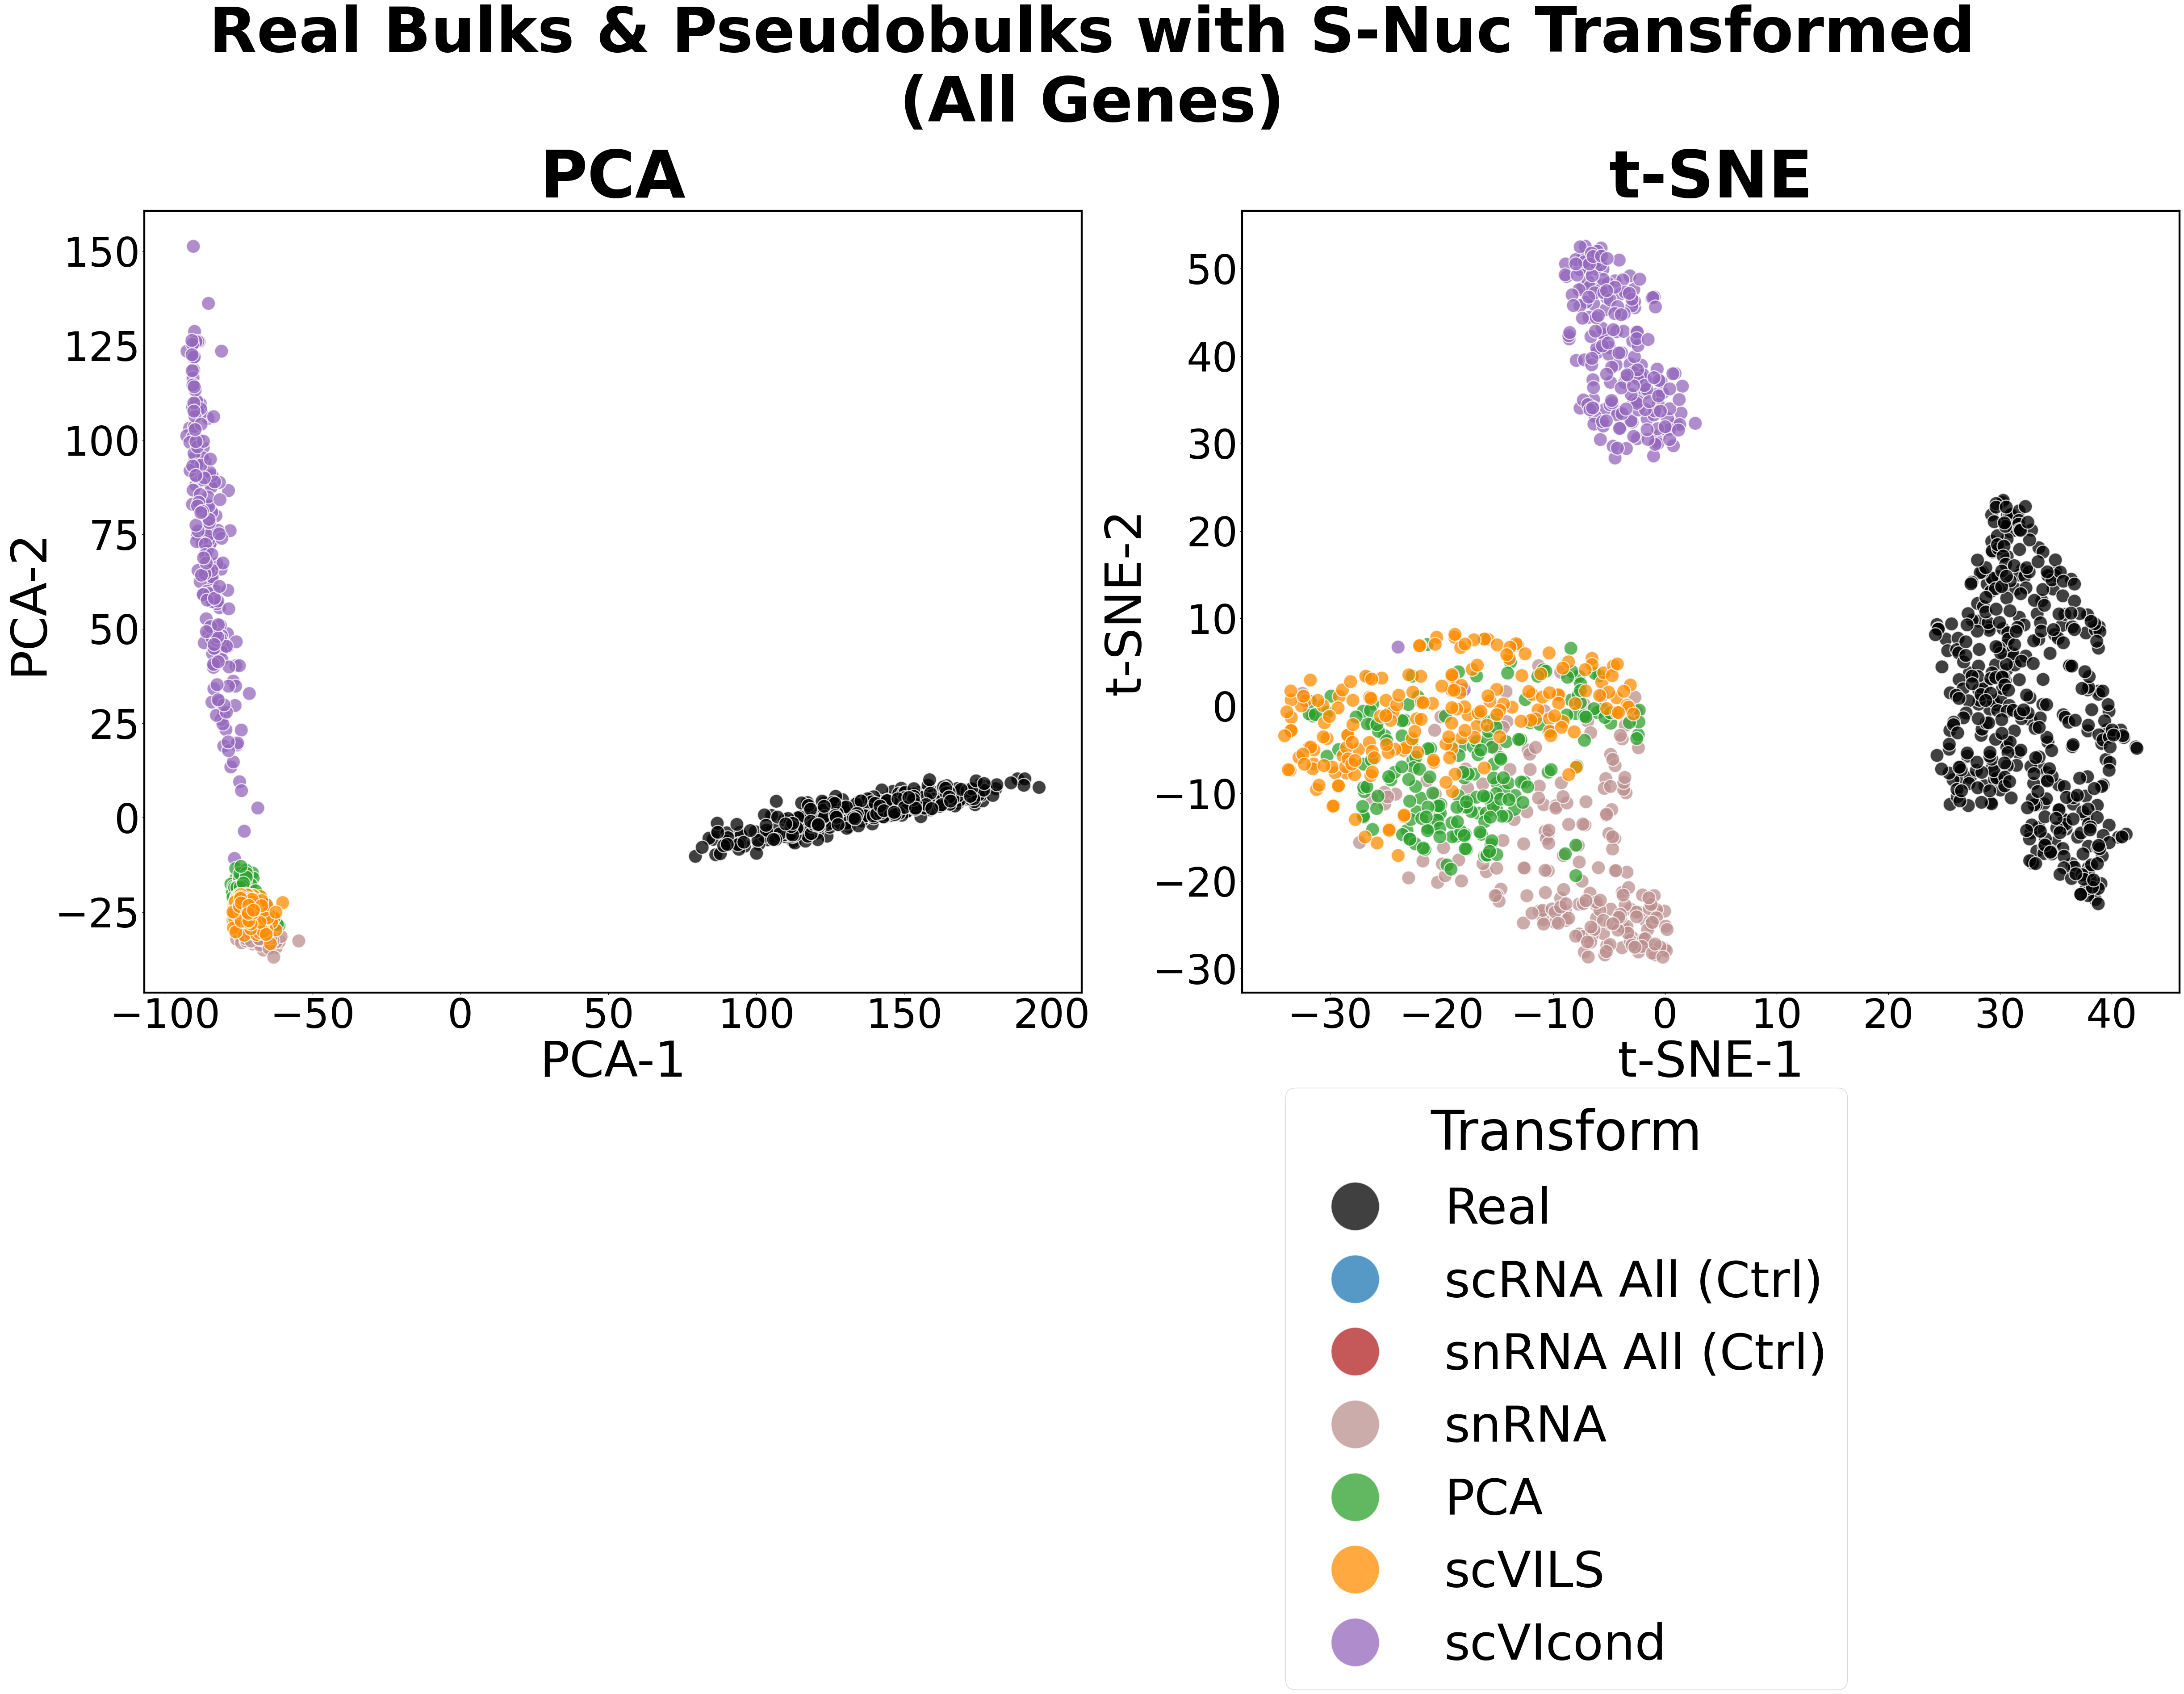

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3065900/2541570844.py:153: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(


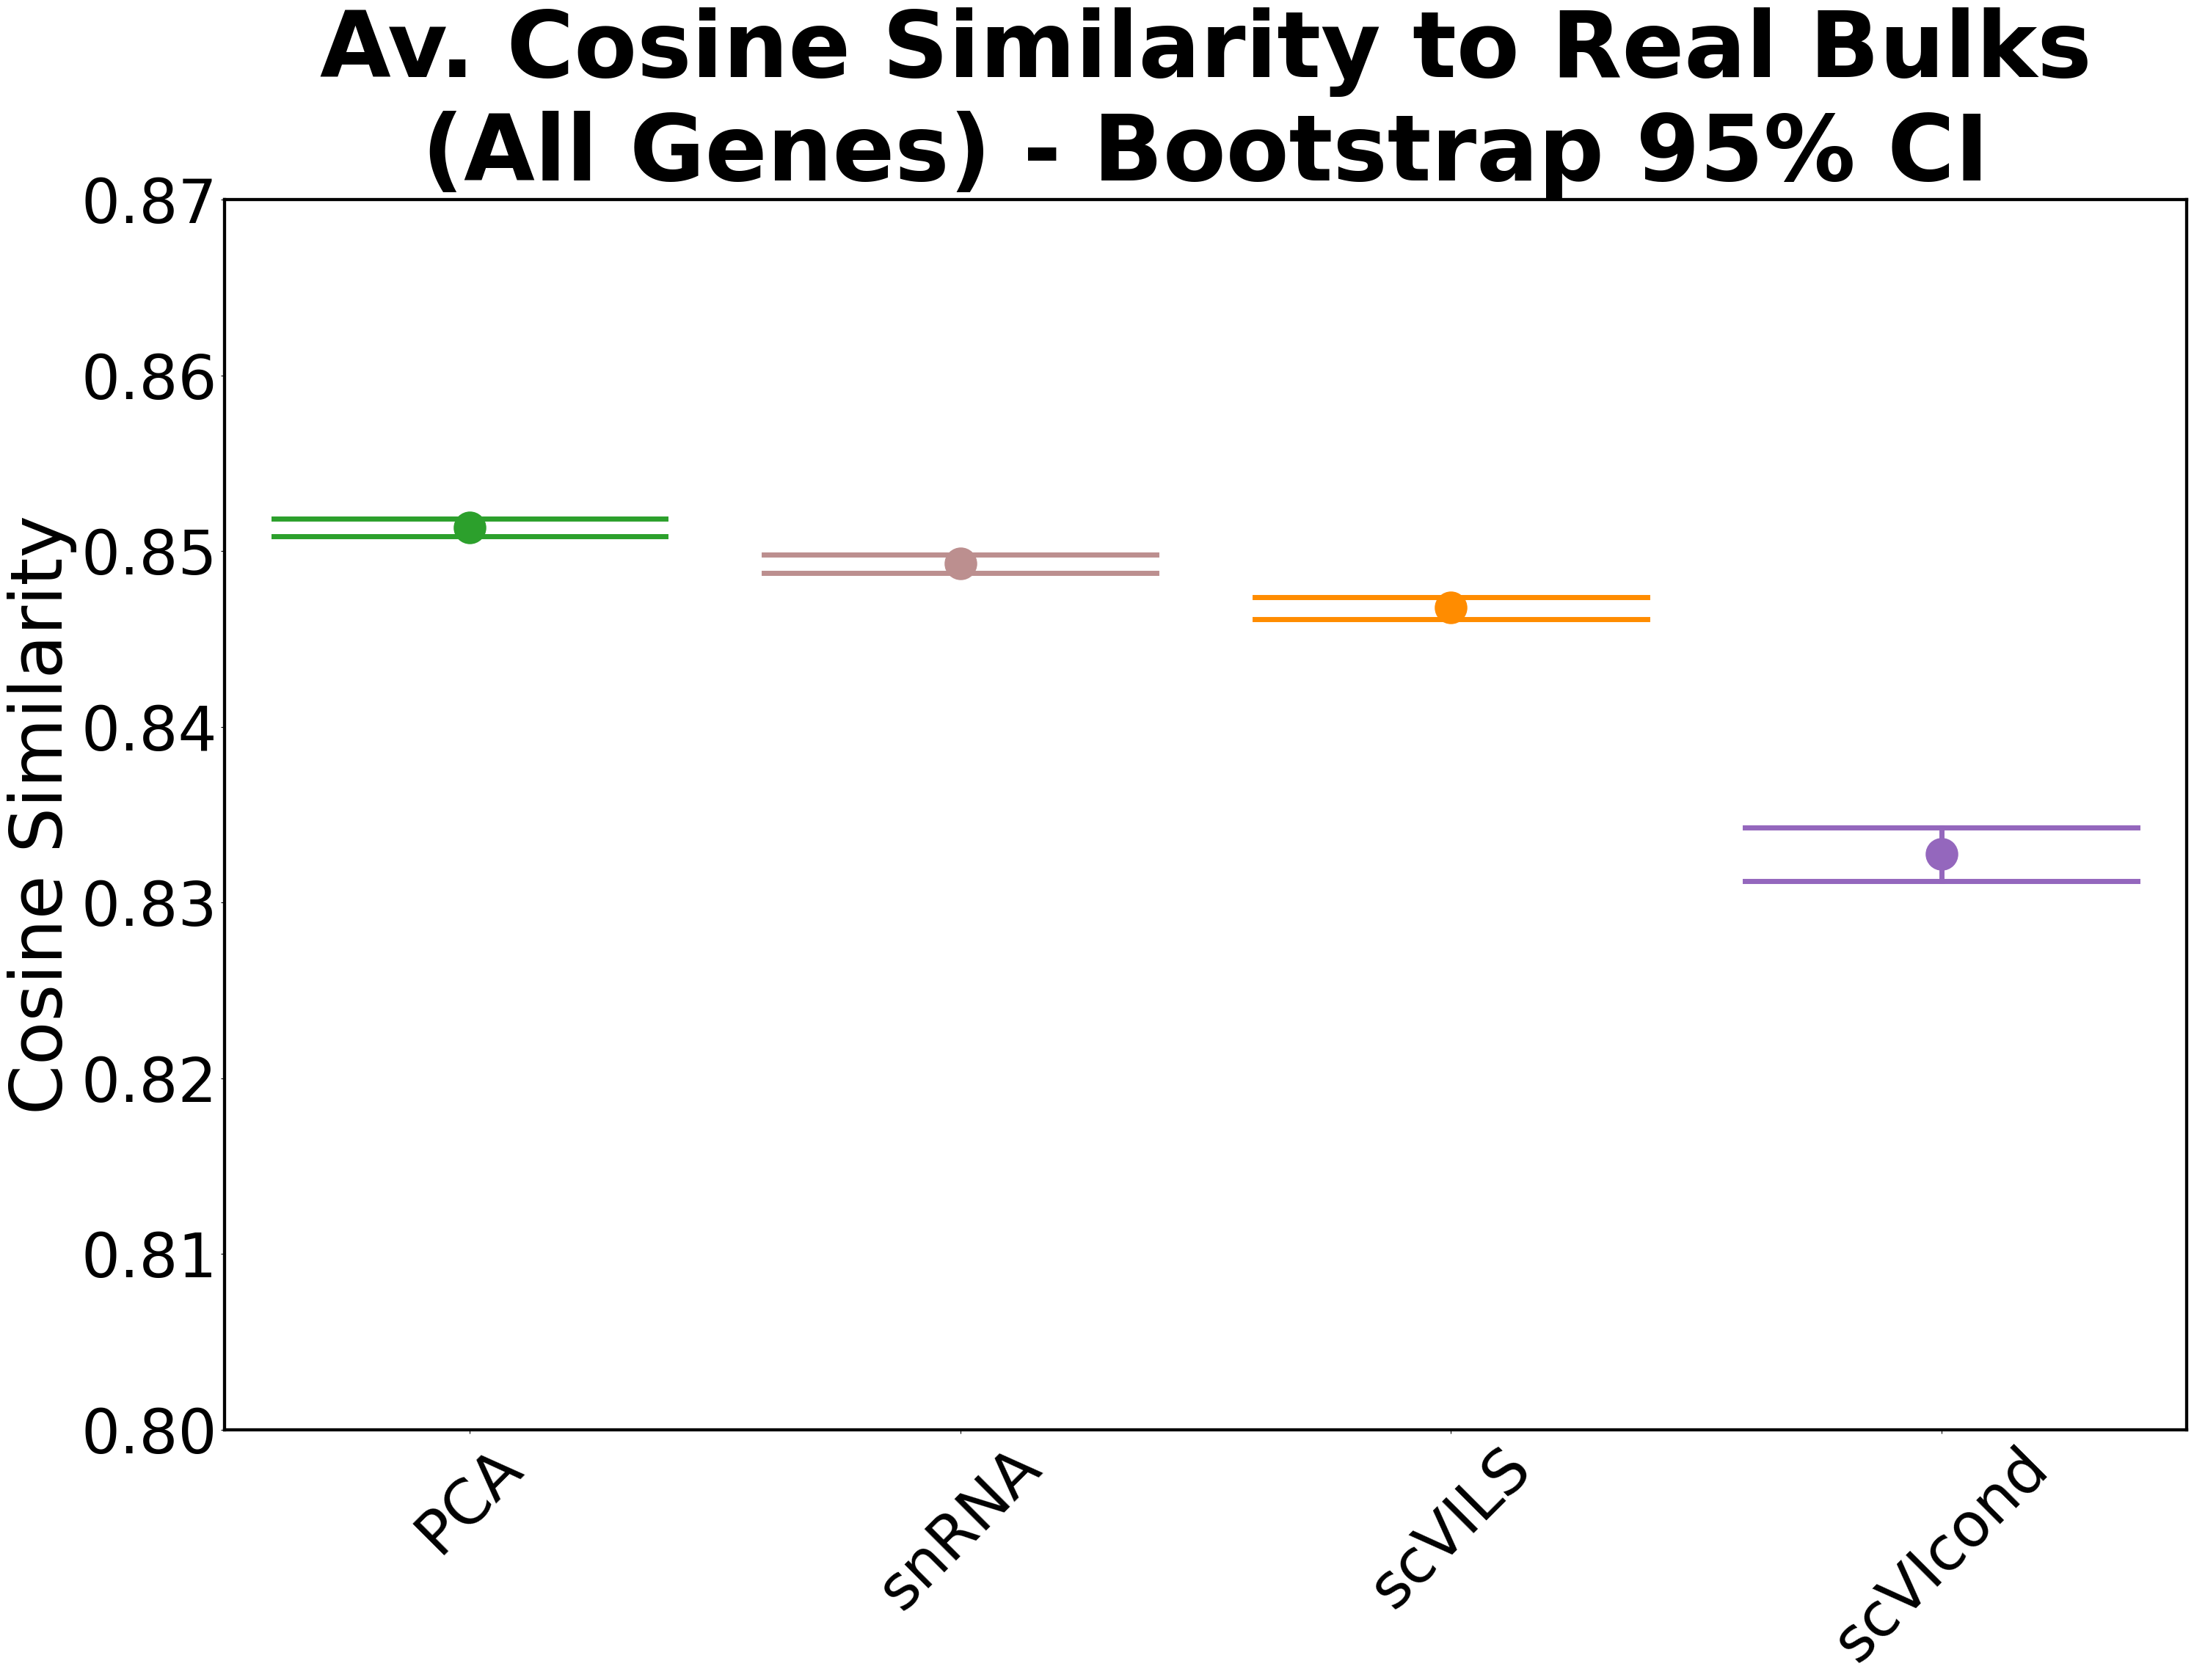

In [15]:
# ----- (A) all genes ---------------------------------------------------------
norm_all, scaler = build_norm_combined(real_df, pseudobulk_dict)
visualize_pca_tsne(norm_all, "(All Genes)", palette=display_palette)
sim_all, lab_all = compute_cosine(norm_all)
plot_mean_ci(sim_all, lab_all, display_palette, "(All Genes)")

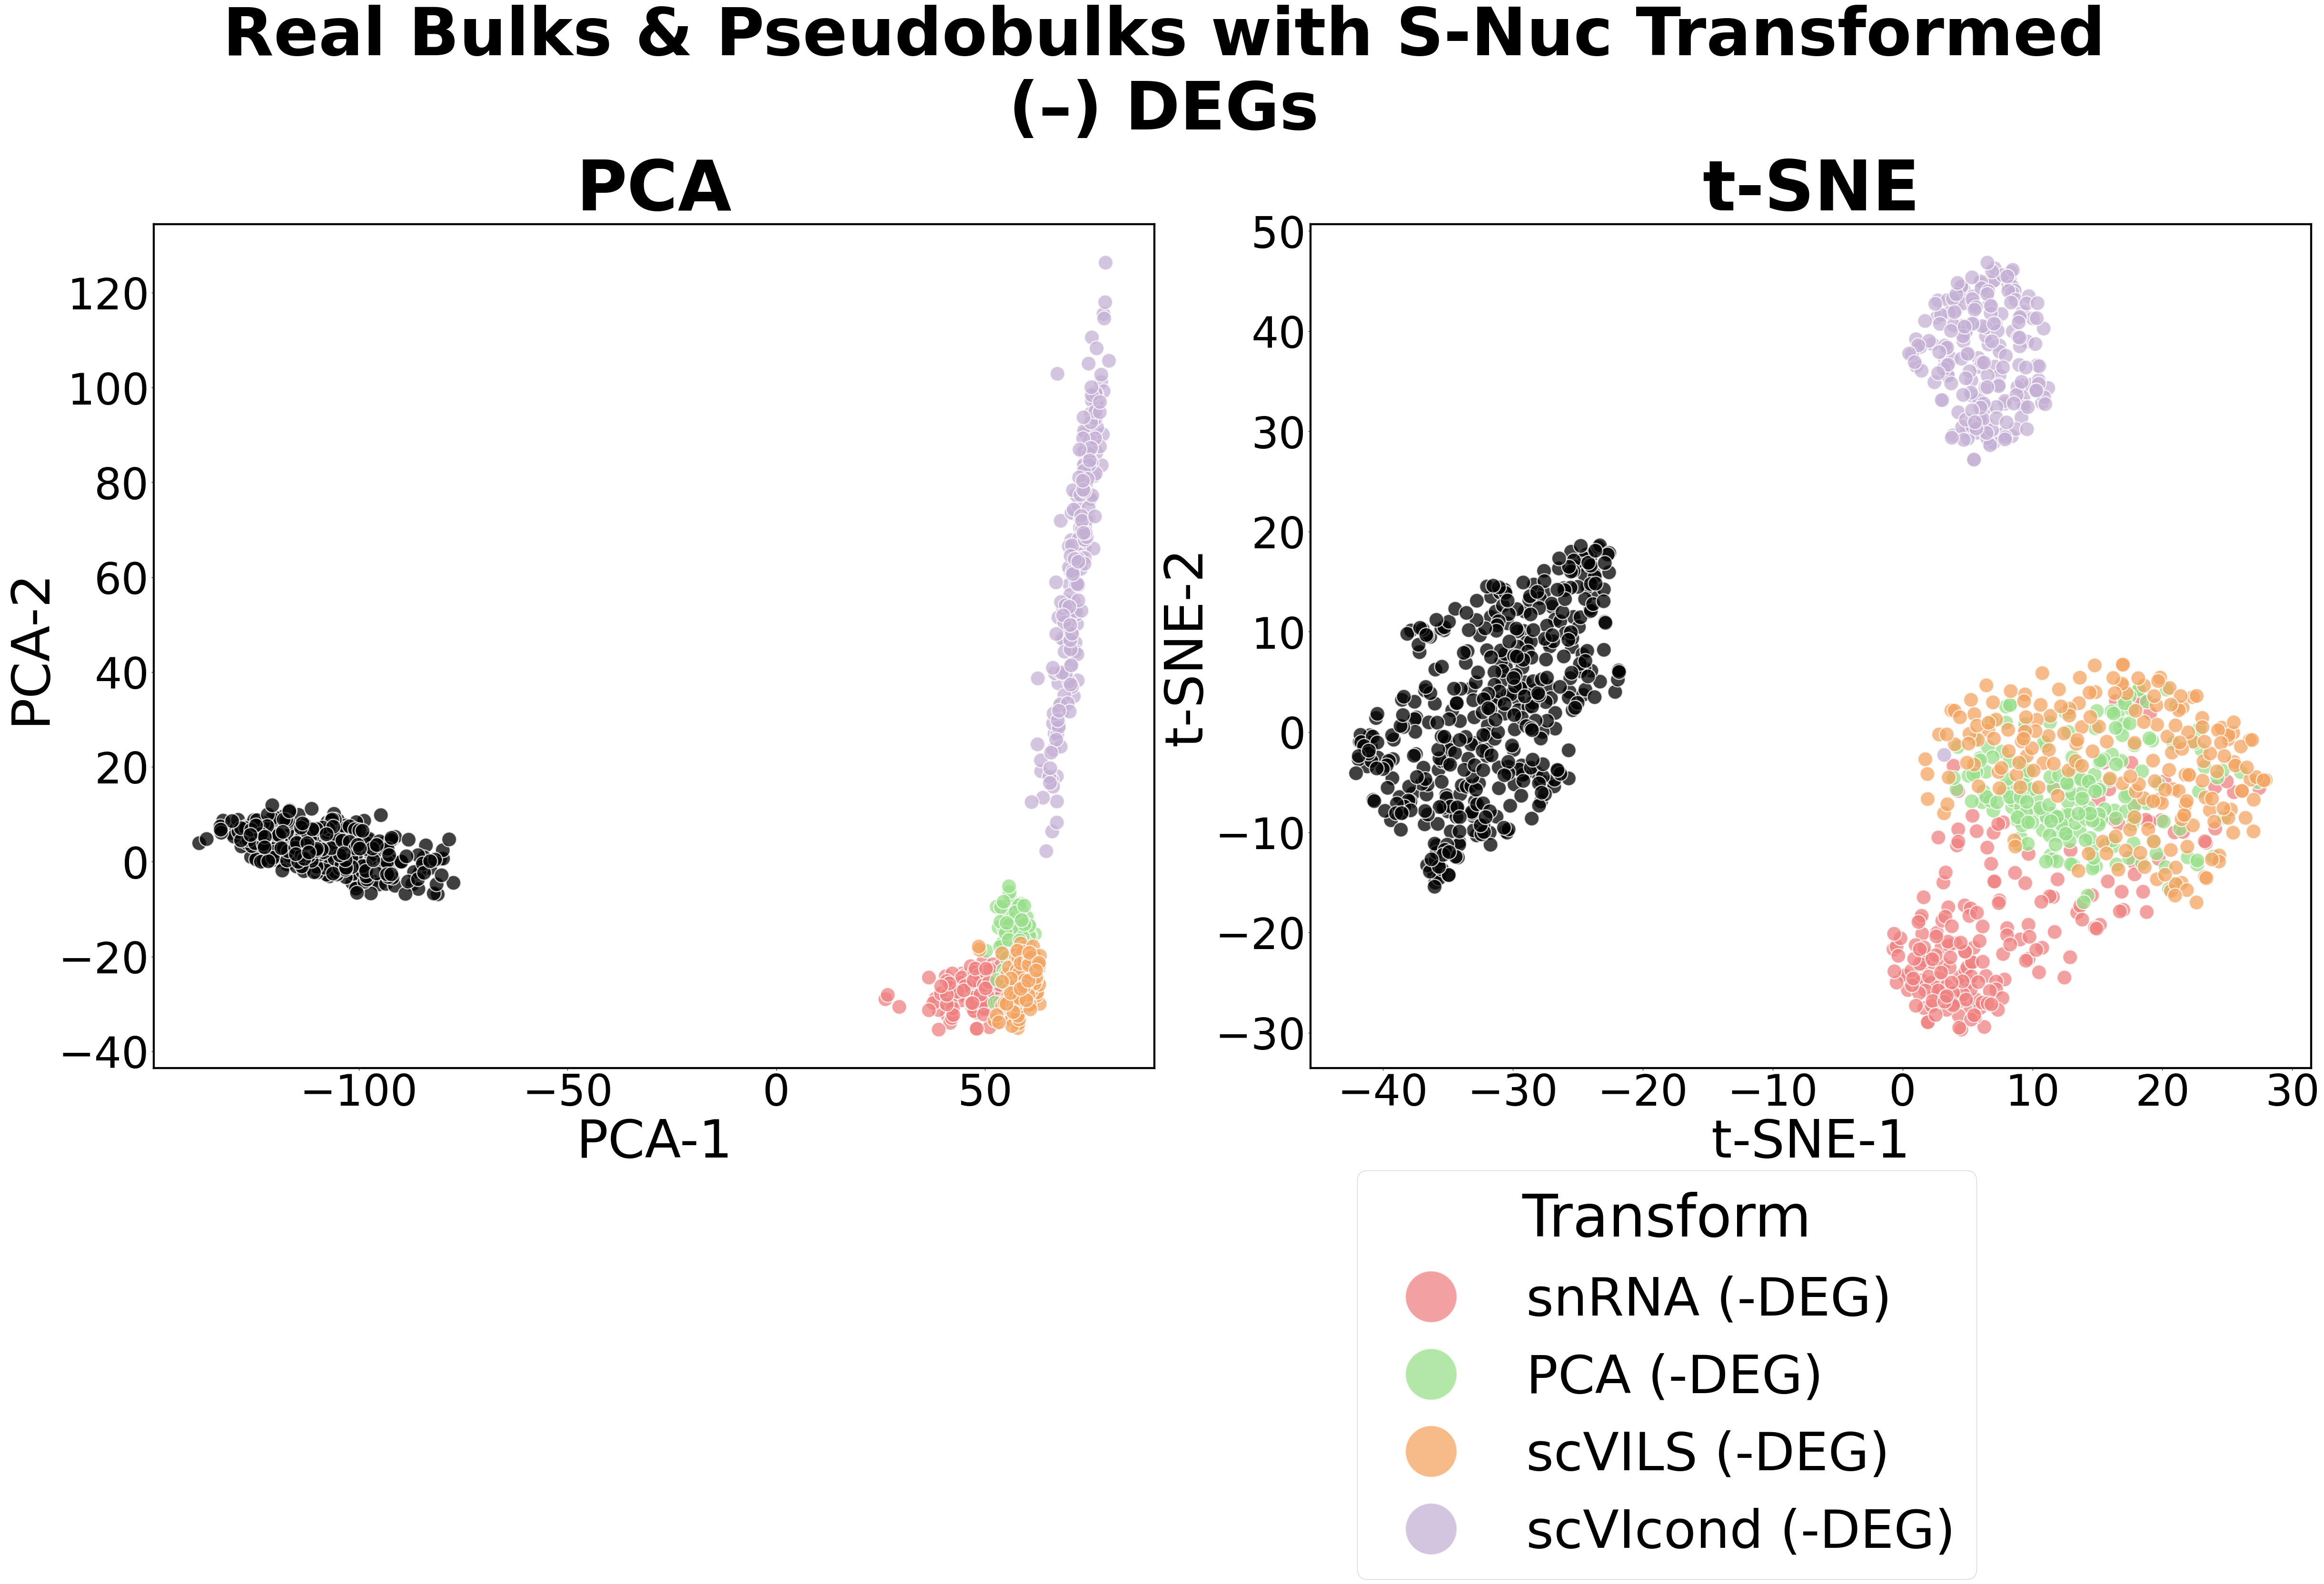

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3065900/2541570844.py:153: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(


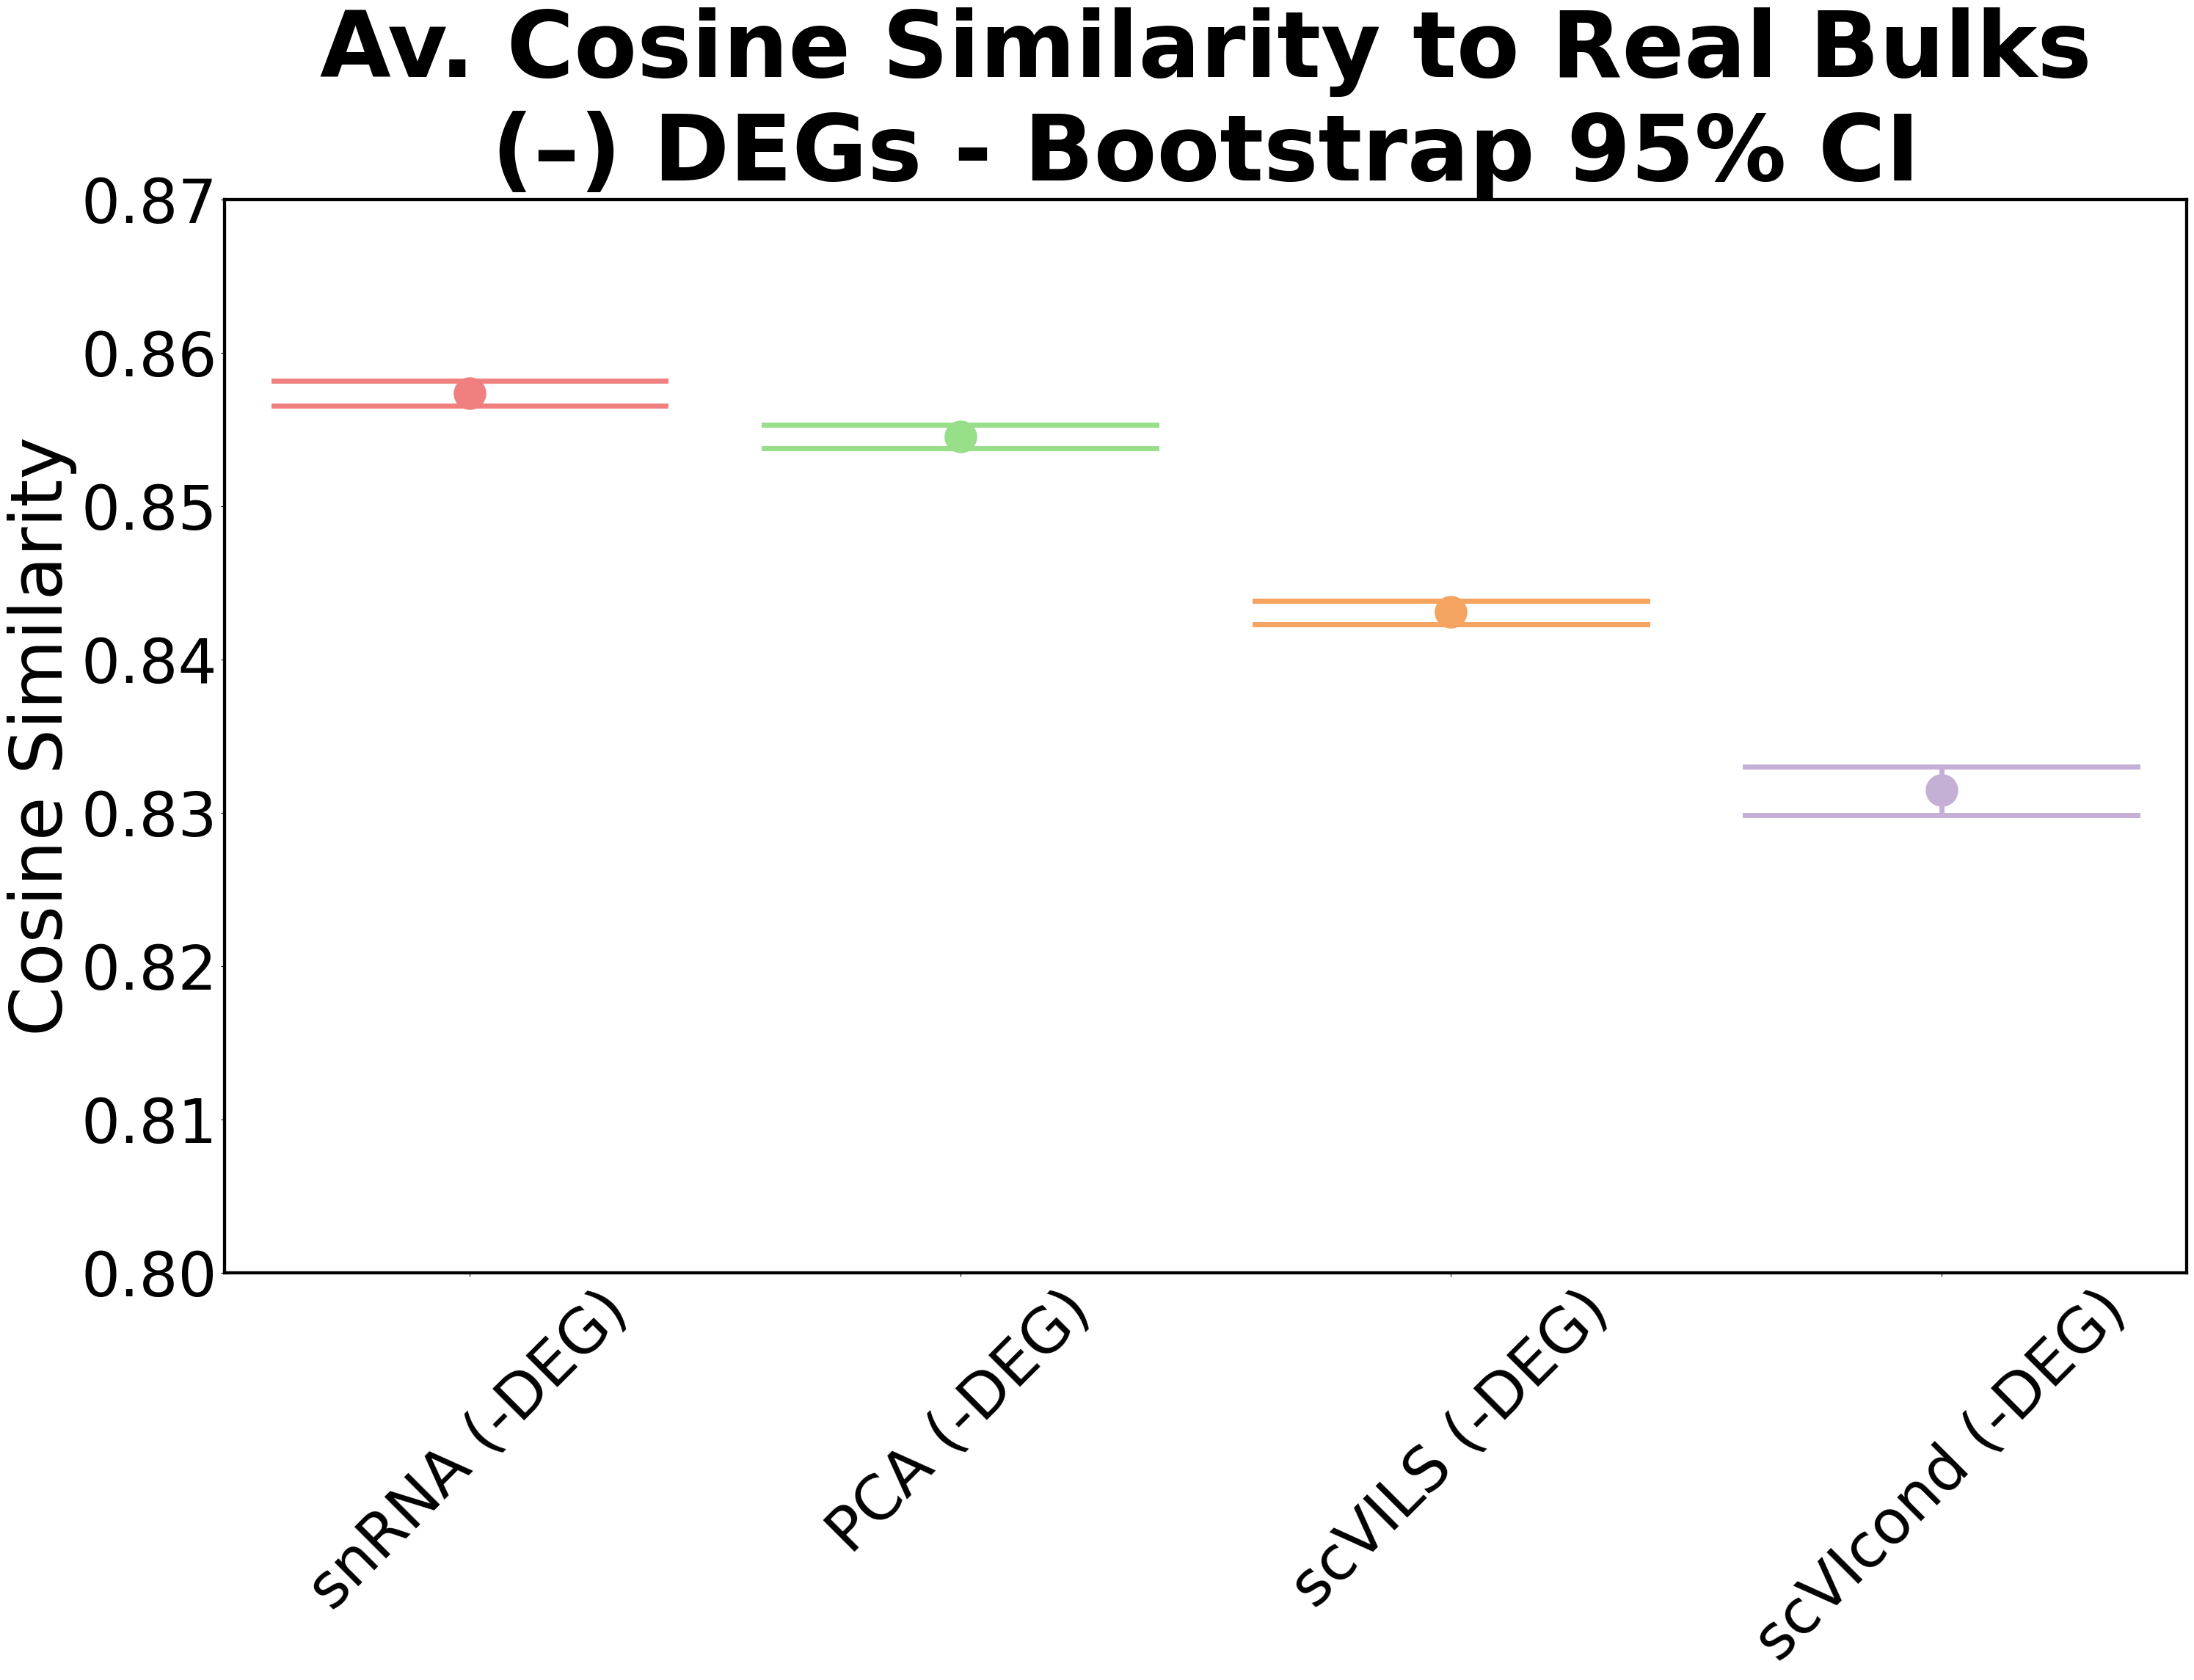

In [16]:
# ----- (B) (–)DEG gene set ---------------------------------------------------
norm_nodeg, _ = build_norm_combined(real_df_nodeg, pseudobulk_nodeg_dict)
visualize_pca_tsne(norm_nodeg, "(–) DEGs", palette=display_palette_deg)
sim_nd, lab_nd = compute_cosine(norm_nodeg)
plot_mean_ci(sim_nd, lab_nd, display_palette_deg, "(–) DEGs")